# Exploratory Data Analysis (EDA)

## 1. Import Library

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## 2. Muat dan Bersihkan Data

In [79]:
print("--- Memuat dan Membersihkan Data ---")

data = pd.read_csv('data.csv')
data = data.drop(columns=['id', 'Unnamed: 32']) # Menghapus kolom yang tidak relevan ('id') atau kosong total ('Unnamed: 32')

print("Data berhasil dimuat dan dibersihkan.")

--- Memuat dan Membersihkan Data ---
Data berhasil dimuat dan dibersihkan.


## 3. Analisis Variabel Target ('diagnosis')


--- Distribusi Kelas Diagnosis ---
diagnosis
B    357
M    212
Name: count, dtype: int64


C:\Users\madea\AppData\Local\Temp\ipykernel_20248\3708482134.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=data, palette='viridis')


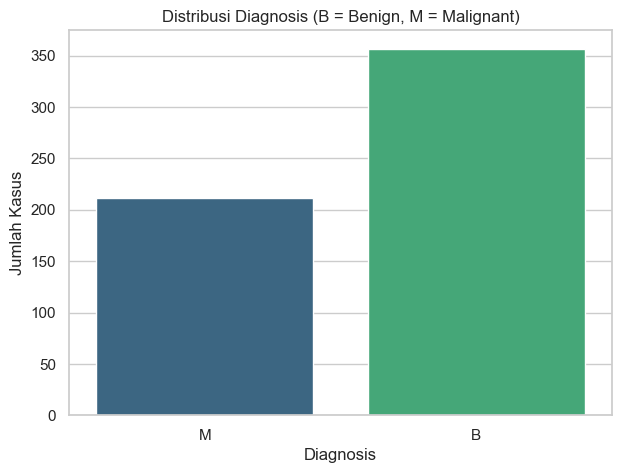

In [80]:
print("\n--- Distribusi Kelas Diagnosis ---")
print(data['diagnosis'].value_counts())

# Visualisasi Distribusi Target
plt.figure(figsize=(7, 5))
sns.countplot(x='diagnosis', data=data, palette='viridis')
plt.title('Distribusi Diagnosis (B = Benign, M = Malignant)')
plt.xlabel('Diagnosis')
plt.ylabel('Jumlah Kasus')
plt.show()

## 4. Analisis Korelasi


--- Menganalisis Korelasi Fitur ---


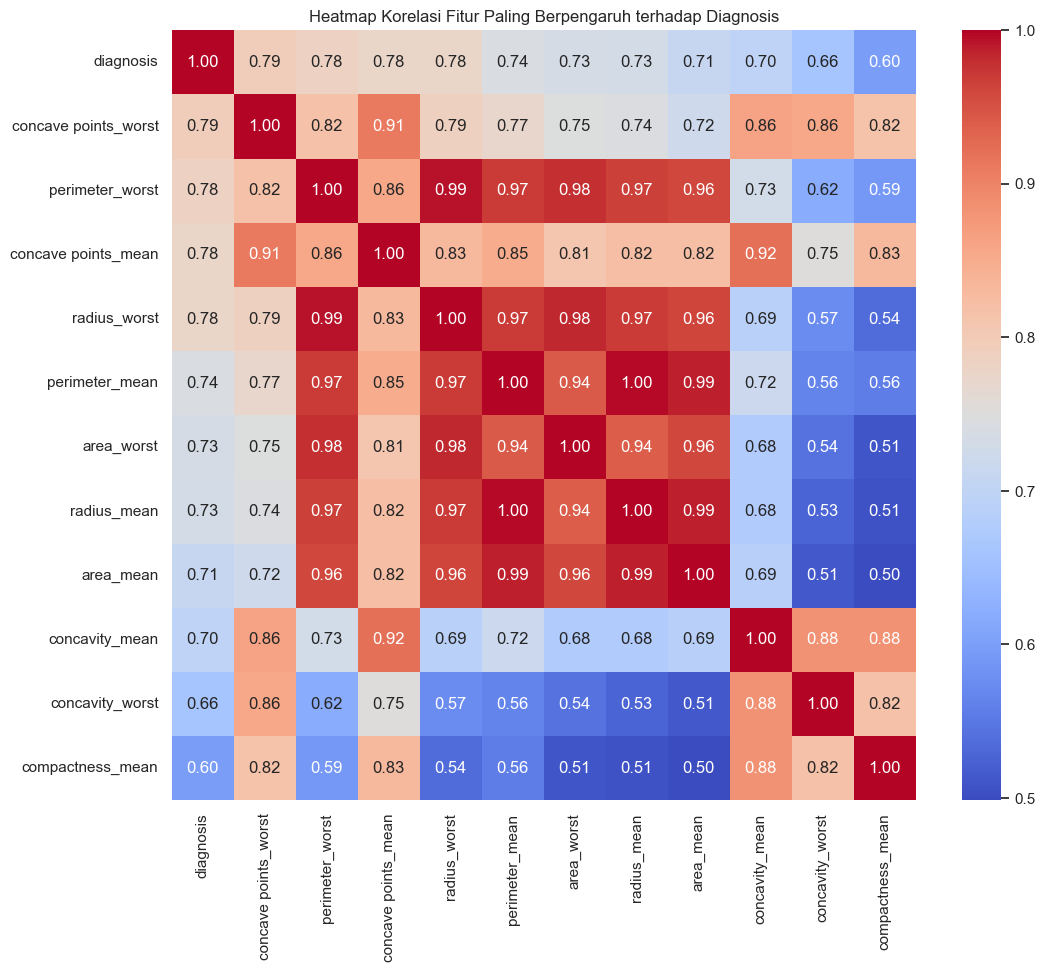

In [81]:
print("\n--- Menganalisis Korelasi Fitur ---")
# Ubah 'diagnosis' menjadi numerik (M=1, B=0) untuk perhitungan korelasi
data_corr = data.copy()
data_corr['diagnosis'] = data_corr['diagnosis'].map({'M': 1, 'B': 0})
correlation_matrix = data_corr.corr()

# Pilih 12 fitur dengan korelasi tertinggi terhadap 'diagnosis' untuk heatmap
top_corr_features = correlation_matrix.nlargest(12, 'diagnosis')['diagnosis'].index
top_corr_matrix = data_corr[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Fitur Paling Berpengaruh terhadap Diagnosis')
plt.show()

# A. Eksperimen Bagging 

## 1. Import library

In [142]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Persiapan Data untuk Pemodelan

In [144]:
# Pisahkan fitur (X) dan target (y)
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# Encode variabel target menjadi numerik (0 dan 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Bagi data menjadi set training (75%) dan testing (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded)
print(f"Data dibagi menjadi {len(X_train)} sampel training dan {len(X_test)} sampel testing.")

# Lakukan scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Data dibagi menjadi 426 sampel training dan 143 sampel testing.


## 3. Evaluasi Baseline Model (Decision Tree)

In [145]:
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=42))
])
# Latih model
baseline_pipeline.fit(X_train, y_train)
# Lakukan prediksi
y_pred_baseline = baseline_pipeline.predict(X_test)
# Hitung metrik performa
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')

# Simpan hasil baseline untuk perbandingan nanti
results = [{
    "Model": "DecisionTree (Baseline)",
    "Best Params": "N/A",
    "Test Accuracy": baseline_accuracy,
    "Test F1-Score": baseline_f1
}]
print(f"Baseline F1-Score: {baseline_f1:.4f}")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

Baseline F1-Score: 0.9577
Baseline Accuracy: 0.9580


## 4. Pencarian Model Terbaik dengan GridSearchCV

In [146]:
models_to_tune = {
    "BaggingClassifier": (BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42), {
        'model__n_estimators': [10, 50, 100, 300, 500],
        'model__max_samples': [ 1, 3, 5, 8, 10],
    }),
    "RandomForestClassifier": (RandomForestClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300, 500],
        'model__max_features': ['sqrt', 'log2', None],
    })
}

print("\n--- Memulai Pencarian Hiperparameter untuk Model Ensemble ---")
for model_name, (model, param_grid) in models_to_tune.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    best_score = -1
    best_params = None
    
    for params in ParameterGrid(param_grid):
        # set parameter ke pipeline
        pipeline.set_params(**params)
        pipeline.fit(X_train, y_train)
        
        # evaluasi di test set langsung
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        if f1 > best_score:  # pilih yang F1 terbaik
            best_score = f1
            best_params = params
            best_accuracy = accuracy
    
    results.append({
        "Model": model_name,
        "Best Params": best_params,
        "Test Accuracy": best_accuracy,
        "Test F1-Score": best_score
    })
    print(f"Selesai untuk {model_name} dengan params terbaik: {best_params}")


--- Memulai Pencarian Hiperparameter untuk Model Ensemble ---
Selesai untuk BaggingClassifier dengan params terbaik: {'model__max_samples': 10, 'model__n_estimators': 300}
Selesai untuk RandomForestClassifier dengan params terbaik: {'model__max_features': 'log2', 'model__n_estimators': 100}


## 5. Tampilkan dan Visualisasikan Hasil


--- Hasil Perbandingan Model Bagging ---
                  Model  Test Accuracy  Test F1-Score
DecisionTree (Baseline)       0.958042       0.957675
      BaggingClassifier       0.937063       0.935642
 RandomForestClassifier       0.972028       0.971784


C:\Users\madea\AppData\Local\Temp\ipykernel_20248\689457796.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='Test F1-Score',
C:\Users\madea\AppData\Local\Temp\ipykernel_20248\689457796.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='Test Accuracy',


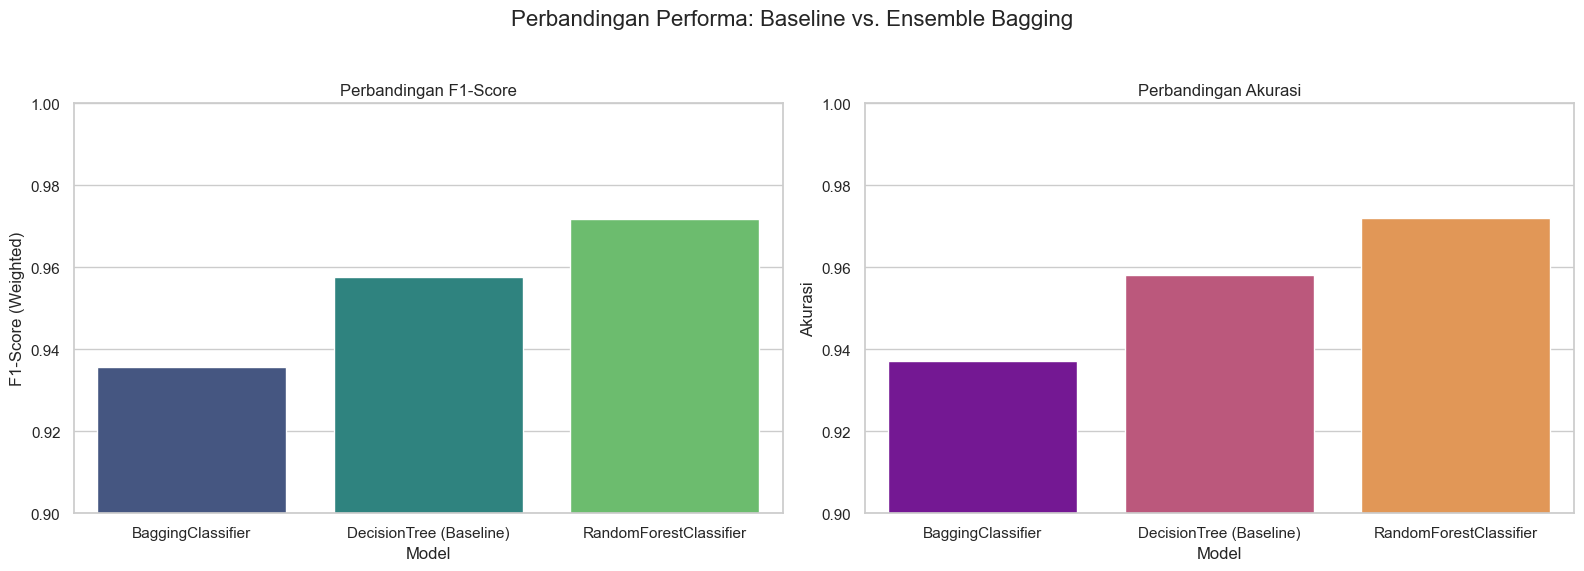

In [147]:
results_bagging_df = pd.DataFrame(results)

print("\n--- Hasil Perbandingan Model Bagging ---")
# Tampilkan hasil hanya Model, Akurasi, dan F1-Score
print(results_bagging_df[['Model', 'Test Accuracy', 'Test F1-Score']].to_string(index=False))

# Visualisasi (tidak diubah)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Perbandingan Performa: Baseline vs. Ensemble Bagging', fontsize=16)

# Grafik 1: F1-Score
sns.barplot(ax=axes[0], x='Model', y='Test F1-Score', 
            data=results_bagging_df.sort_values('Test F1-Score'), palette='viridis')
axes[0].set_title('Perbandingan F1-Score')
axes[0].set_ylabel('F1-Score (Weighted)')
axes[0].set_ylim(0.9, 1.0)

# Grafik 2: Akurasi
sns.barplot(ax=axes[1], x='Model', y='Test Accuracy', 
            data=results_bagging_df.sort_values('Test Accuracy'), palette='plasma')
axes[1].set_title('Perbandingan Akurasi')
axes[1].set_ylabel('Akurasi')
axes[1].set_ylim(0.9, 1.0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# B. Eksperimen Boosting

## 1. Import library

In [148]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 2. Evaluasi Baseline Model (Decision Tree)

In [149]:
results_boosting = []

# Baseline 1: Decision Tree
baseline_dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=42))
])
baseline_dt_pipeline.fit(X_train, y_train)
y_pred_dt = baseline_dt_pipeline.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='weighted')
results_boosting.append({
    "Model": "DecisionTree (Baseline)",
    "Best Params": "N/A",
    "Test Accuracy": dt_accuracy,
    "Test F1-Score": dt_f1
})
print(f"Baseline DecisionTree F1-Score: {dt_f1:.4f}")
print(f"Baseline DecisionTree Accuracy: {dt_accuracy:.4f}")

# Baseline 2: Logistic Regression
baseline_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])
baseline_lr_pipeline.fit(X_train, y_train)
y_pred_lr = baseline_lr_pipeline.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')
results_boosting.append({
    "Model": "LogisticRegression (Baseline)",
    "Best Params": "N/A",
    "Test Accuracy": lr_accuracy,
    "Test F1-Score": lr_f1
})
print(f"Baseline LogisticRegression F1-Score: {lr_f1:.4f}")
print(f"Baseline LogisticRegression Accuracy: {lr_accuracy:.4f}")

Baseline DecisionTree F1-Score: 0.9577
Baseline DecisionTree Accuracy: 0.9580
Baseline LogisticRegression F1-Score: 0.9648
Baseline LogisticRegression Accuracy: 0.9650


## 3. Pencarian Model Boosting Terbaik dengan GridSearchCV

In [150]:
models_to_tune = {
    "AdaBoost": (AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42), {
        'model__n_estimators': [50, 100, 200, 300, 500, 1000],
        'model__learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0]
    }),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300, 500, 1000],
        'model__learning_rate': [ 0.01, 0.1, 0.3, 0.5, 1.0],
        'model__max_depth': [3, 5, 7, 9]
    }),
    "XGBoost": (XGBClassifier(eval_metric='logloss', random_state=42), {
        'model__n_estimators': [50, 100, 200, 300, 500],
        'model__learning_rate': [0.01, 0.1, 0.3, 0.5, 1.0],
        'model__subsample': [0.5, 0.8, 1.0]
    })
}

print("\n--- Memulai Pencarian Hiperparameter untuk Model Boosting ---")

for model_name, (model, param_grid) in models_to_tune.items():
    start_time = time.time()
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    best_score = -1
    best_params = None
    best_accuracy = None
    
    # loop semua kombinasi parameter
    for params in ParameterGrid(param_grid):
        pipeline.set_params(**params)
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # simpan yang terbaik berdasarkan F1
        if f1 > best_score:
            best_score = f1
            best_params = params
            best_accuracy = accuracy
    
    end_time = time.time()
    duration = end_time - start_time
    
    results_boosting.append({
        "Model": model_name,
        "Best Params": best_params,
        "Test Accuracy": best_accuracy,
        "Test F1-Score": best_score
    })
    
    print(f"Selesai untuk {model_name} | Best F1: {best_score:.4f}, Best Acc: {best_accuracy:.4f}, waktu: {duration:.2f} detik")


--- Memulai Pencarian Hiperparameter untuk Model Boosting ---
Selesai untuk AdaBoost | Best F1: 0.9789, Best Acc: 0.9790, waktu: 25.39 detik
Selesai untuk GradientBoosting | Best F1: 0.9646, Best Acc: 0.9650, waktu: 106.15 detik
Selesai untuk XGBoost | Best F1: 0.9860, Best Acc: 0.9860, waktu: 7.34 detik


## 4. Tampilkan dan Visualisasikan Hasil


--- Hasil Perbandingan Model Boosting (dengan 2 Baseline) ---
                        Model  Test Accuracy  Test F1-Score
      DecisionTree (Baseline)       0.958042       0.957675
LogisticRegression (Baseline)       0.965035       0.964812
                     AdaBoost       0.979021       0.978887
             GradientBoosting       0.965035       0.964642
                      XGBoost       0.986014       0.985956


C:\Users\madea\AppData\Local\Temp\ipykernel_20248\12854086.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='Test F1-Score', data=results_boosting_df.sort_values('Test F1-Score'), palette='crest')
C:\Users\madea\AppData\Local\Temp\ipykernel_20248\12854086.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='Test Accuracy', data=results_boosting_df.sort_values('Test Accuracy'), palette='magma')


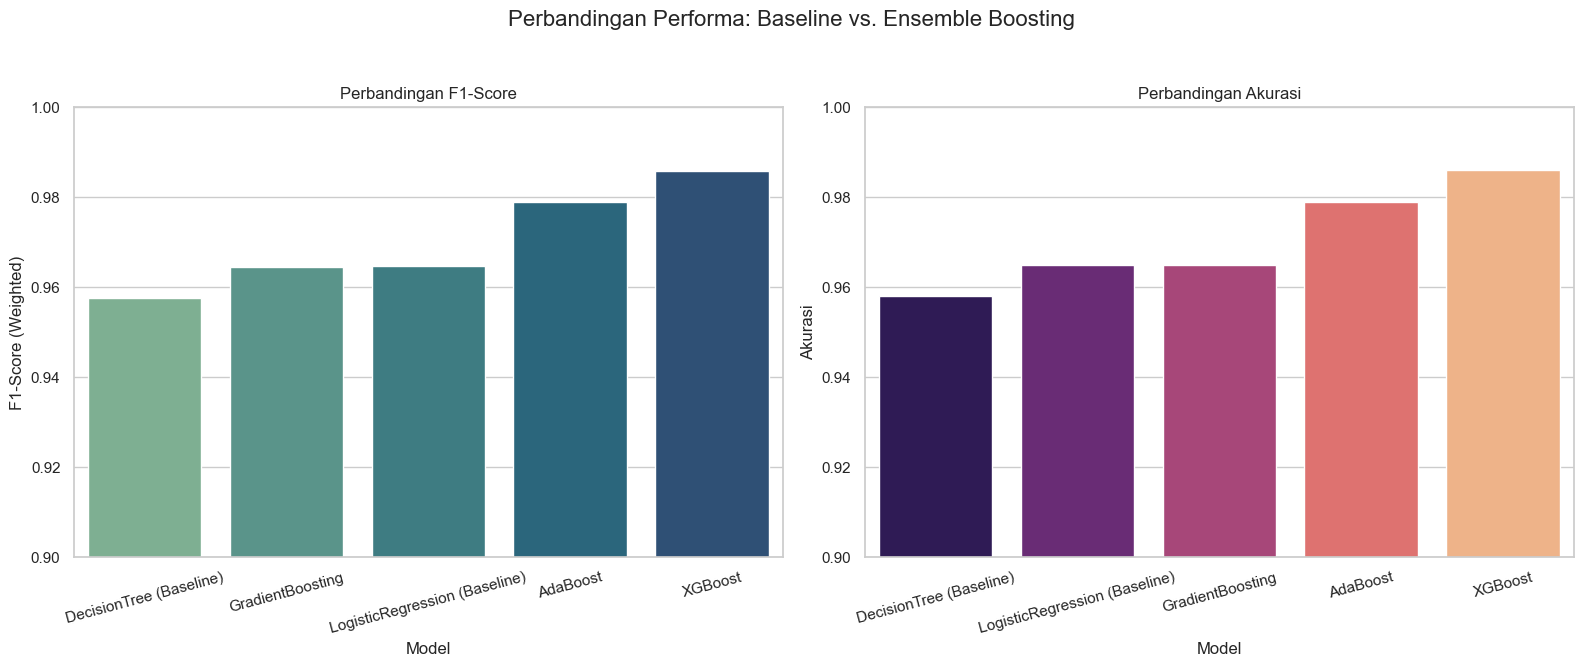

In [151]:
results_boosting_df = pd.DataFrame(results_boosting)
print("\n--- Hasil Perbandingan Model Boosting (dengan 2 Baseline) ---")
print(results_boosting_df[['Model', 'Test Accuracy', 'Test F1-Score']].to_string(index=False))

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Perbandingan Performa: Baseline vs. Ensemble Boosting', fontsize=16)

# Grafik 1: F1-Score
sns.barplot(ax=axes[0], x='Model', y='Test F1-Score', data=results_boosting_df.sort_values('Test F1-Score'), palette='crest')
axes[0].set_title('Perbandingan F1-Score')
axes[0].set_ylabel('F1-Score (Weighted)')
axes[0].set_ylim(0.9, 1.0)
axes[0].tick_params(axis='x', rotation=15)

# Grafik 2: Akurasi
sns.barplot(ax=axes[1], x='Model', y='Test Accuracy', data=results_boosting_df.sort_values('Test Accuracy'), palette='magma')
axes[1].set_title('Perbandingan Akurasi')
axes[1].set_ylabel('Akurasi')
axes[1].set_ylim(0.9, 1.0)
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# C. Experimen Stacking

## 1. Import library

In [152]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

## 2. Definisikan Base Models dan Meta Model

In [153]:
base_models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=42))]),
    'DecisionTree': Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(random_state=42))]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state=42))]),
    'RandomForest': Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))]),
    'AdaBoost': Pipeline([('scaler', StandardScaler()), ('ada', AdaBoostClassifier(random_state=42))]),
    'GradientBoosting': Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingClassifier(random_state=42))])
}

# Meta model (final estimator) sesuai permintaan
meta_model = LogisticRegression()

## 3. Evaluasi Performa Model Individual (sebagai perbandingan)

In [158]:
print("--- Mengevaluasi Performa Model Individual ---")
results_stacking = []
# Gunakan 5-fold cross-validation
cv_method = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in base_models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    duration = time.time() - start_time
    
    results_stacking.append({"Model": model_name, "Test Accuracy": acc, "Test F1-Score": f1})
    print(f"Selesai untuk {model_name} dalam {duration:.2f} detik | Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

--- Mengevaluasi Performa Model Individual ---
Selesai untuk LogisticRegression dalam 0.02 detik | Accuracy: 0.9650, F1-Score: 0.9648
Selesai untuk DecisionTree dalam 0.01 detik | Accuracy: 0.9580, F1-Score: 0.9577
Selesai untuk SVM dalam 0.01 detik | Accuracy: 0.9720, F1-Score: 0.9718
Selesai untuk RandomForest dalam 0.15 detik | Accuracy: 0.9650, F1-Score: 0.9646
Selesai untuk AdaBoost dalam 0.16 detik | Accuracy: 0.9720, F1-Score: 0.9718
Selesai untuk GradientBoosting dalam 0.37 detik | Accuracy: 0.9650, F1-Score: 0.9646


## 4. Definisikan dan Evaluasi Kombinasi Stacking

In [155]:
stacking_combinations = {
    "Kombinasi 1 (DT, LR, Ada)": [
        ('dt', base_models['DecisionTree']),
        ('lr', base_models['LogisticRegression']),
        ('ada', base_models['AdaBoost'])
    ],
    "Kombinasi 2 (RF, GB, SVM)": [
        ('rf', base_models['RandomForest']),
        ('gb', base_models['GradientBoosting']),
        ('svm', base_models['SVM'])
    ],
    "Kombinasi 3 (Ada, SVM, DT)": [
        ('ada', base_models['AdaBoost']),
        ('svm', base_models['SVM']),
        ('dt', base_models['DecisionTree'])
    ]
}

print("\n--- Mengevaluasi Kombinasi Stacking (Tanpa K-Fold) ---")
for combo_name, combo_models in stacking_combinations.items():
    stacking_model = StackingClassifier(estimators=combo_models, final_estimator=meta_model, n_jobs=-1)
    
    # Evaluasi langsung pada train-test split
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results_stacking.append({"Model": combo_name + " (No CV)", "Test Accuracy": acc, "Test F1-Score": f1})
    print(f"Selesai untuk {combo_name} (No CV) | Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")


print("\n--- Mengevaluasi Kombinasi Stacking (Dengan 5-Fold CV) ---")
for combo_name, combo_models in stacking_combinations.items():
    stacking_model = StackingClassifier(estimators=combo_models, final_estimator=meta_model, cv=cv_method, n_jobs=-1)
    
    # Evaluasi dengan cross-validation
    acc = np.mean(cross_val_score(stacking_model, X, y_encoded, cv=cv_method, scoring='accuracy'))
    f1 = np.mean(cross_val_score(stacking_model, X, y_encoded, cv=cv_method, scoring='f1_weighted'))
    
    results_stacking.append({"Model": combo_name + " (5-Fold CV)", "Test Accuracy": acc, "Test F1-Score": f1})
    print(f"Selesai untuk {combo_name} (5-Fold CV) | Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")


--- Mengevaluasi Kombinasi Stacking (5-Fold CV) ---

--- Mengevaluasi Kombinasi Stacking (Tanpa K-Fold) ---
Selesai untuk Kombinasi 1 (DT, LR, Ada) (No CV) | Accuracy: 0.9720, F1-Score: 0.9718
Selesai untuk Kombinasi 2 (RF, GB, SVM) (No CV) | Accuracy: 0.9720, F1-Score: 0.9718
Selesai untuk Kombinasi 3 (Ada, SVM, DT) (No CV) | Accuracy: 0.9860, F1-Score: 0.9860

--- Mengevaluasi Kombinasi Stacking (Dengan 5-Fold CV) ---
Selesai untuk Kombinasi 1 (DT, LR, Ada) (5-Fold CV) | Accuracy: 0.9789, F1-Score: 0.9788
Selesai untuk Kombinasi 2 (RF, GB, SVM) (5-Fold CV) | Accuracy: 0.9771, F1-Score: 0.9771
Selesai untuk Kombinasi 3 (Ada, SVM, DT) (5-Fold CV) | Accuracy: 0.9754, F1-Score: 0.9754



--- Hasil Perbandingan Stacking (No CV vs 5-Fold CV) ---
                                 Model  Test Accuracy  Test F1-Score
     Kombinasi 1 (DT, LR, Ada) (No CV)       0.972028       0.971784
     Kombinasi 2 (RF, GB, SVM) (No CV)       0.972028       0.971784
    Kombinasi 3 (Ada, SVM, DT) (No CV)       0.986014       0.985956
 Kombinasi 1 (DT, LR, Ada) (5-Fold CV)       0.978901       0.978805
 Kombinasi 2 (RF, GB, SVM) (5-Fold CV)       0.977146       0.977125
Kombinasi 3 (Ada, SVM, DT) (5-Fold CV)       0.975408       0.975401


C:\Users\madea\AppData\Local\Temp\ipykernel_20248\2930661043.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='Test F1-Score', data=stacking_only_df, palette='Set2')
C:\Users\madea\AppData\Local\Temp\ipykernel_20248\2930661043.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='Test Accuracy', data=stacking_only_df, palette='Set3')


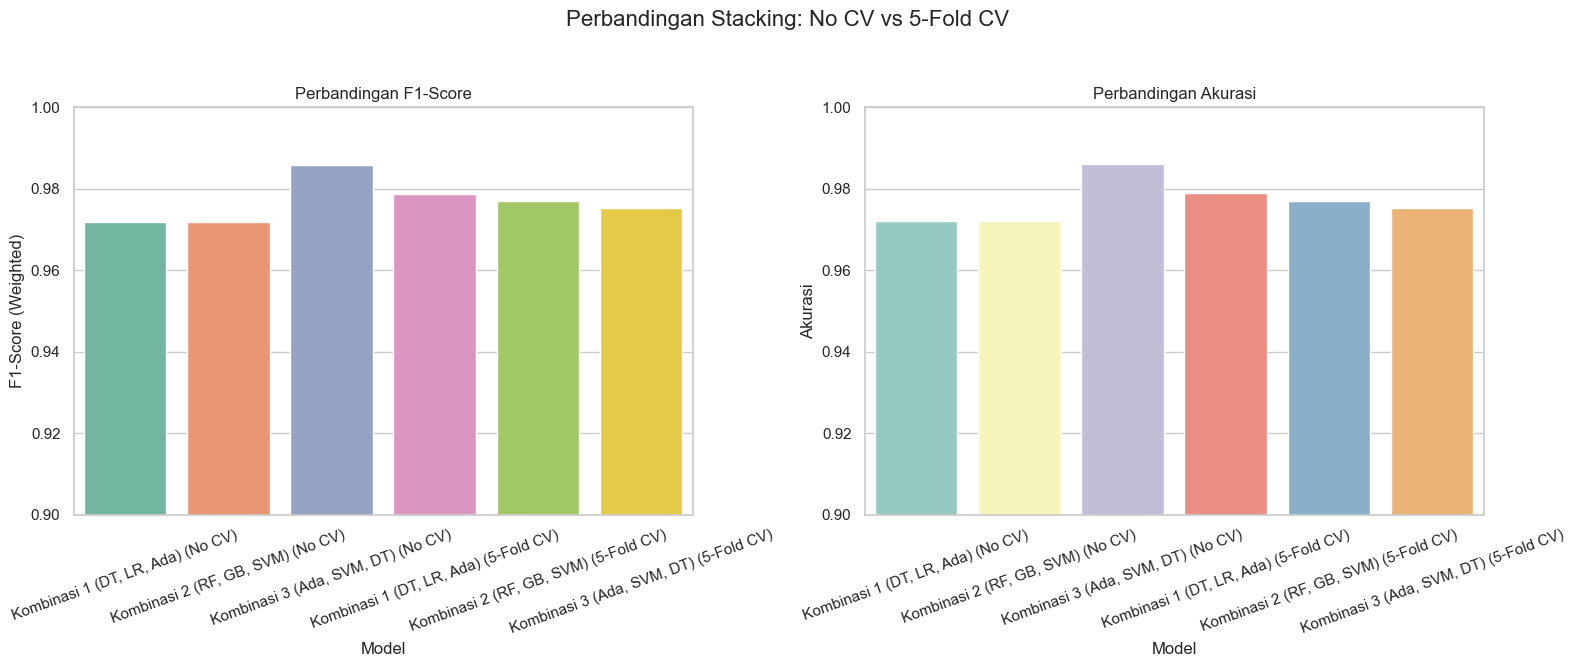

In [156]:
# Ubah hasil ke DataFrame
results_stacking_df = pd.DataFrame(results_stacking)

# Filter hanya model kombinasi (biar jelas perbandingan No CV vs CV)
stacking_only_df = results_stacking_df[
    results_stacking_df['Model'].str.contains("Kombinasi")
]

print("\n--- Hasil Perbandingan Stacking (No CV vs 5-Fold CV) ---")
print(stacking_only_df[['Model', 'Test Accuracy', 'Test F1-Score']].to_string(index=False))

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Perbandingan Stacking: No CV vs 5-Fold CV', fontsize=16)

# Grafik 1: F1-Score
sns.barplot(ax=axes[0], x='Model', y='Test F1-Score', data=stacking_only_df, palette='Set2')
axes[0].set_title('Perbandingan F1-Score')
axes[0].set_ylabel('F1-Score (Weighted)')
axes[0].set_ylim(0.9, 1.0)
axes[0].tick_params(axis='x', rotation=20)

# Grafik 2: Akurasi
sns.barplot(ax=axes[1], x='Model', y='Test Accuracy', data=stacking_only_df, palette='Set3')
axes[1].set_title('Perbandingan Akurasi')
axes[1].set_ylabel('Akurasi')
axes[1].set_ylim(0.9, 1.0)
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 5. Tampilkan dan Visualisasikan Hasil Akhir


--- Hasil Perbandingan Model Stacking dan Individual ---
                                     Model  Test Accuracy  Test F1-Score
0                       LogisticRegression       0.965035       0.964812
1                             DecisionTree       0.958042       0.957675
2                                      SVM       0.972028       0.971784
3                             RandomForest       0.965035       0.964642
4                                 AdaBoost       0.972028       0.971784
5                         GradientBoosting       0.965035       0.964642
6        Kombinasi 1 (DT, LR, Ada) (No CV)       0.972028       0.971784
7        Kombinasi 2 (RF, GB, SVM) (No CV)       0.972028       0.971784
8       Kombinasi 3 (Ada, SVM, DT) (No CV)       0.986014       0.985956
9    Kombinasi 1 (DT, LR, Ada) (5-Fold CV)       0.978901       0.978805
10   Kombinasi 2 (RF, GB, SVM) (5-Fold CV)       0.977146       0.977125
11  Kombinasi 3 (Ada, SVM, DT) (5-Fold CV)       0.975408       0.

C:\Users\madea\AppData\Local\Temp\ipykernel_20248\1947772606.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(ax=axes[0], x='Test F1-Score', y='Model', data=sorted_df_f1, palette='viridis', orient='h')
C:\Users\madea\AppData\Local\Temp\ipykernel_20248\1947772606.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(ax=axes[1], x='Test Accuracy', y='Model', data=sorted_df_acc, palette='plasma', orient='h')


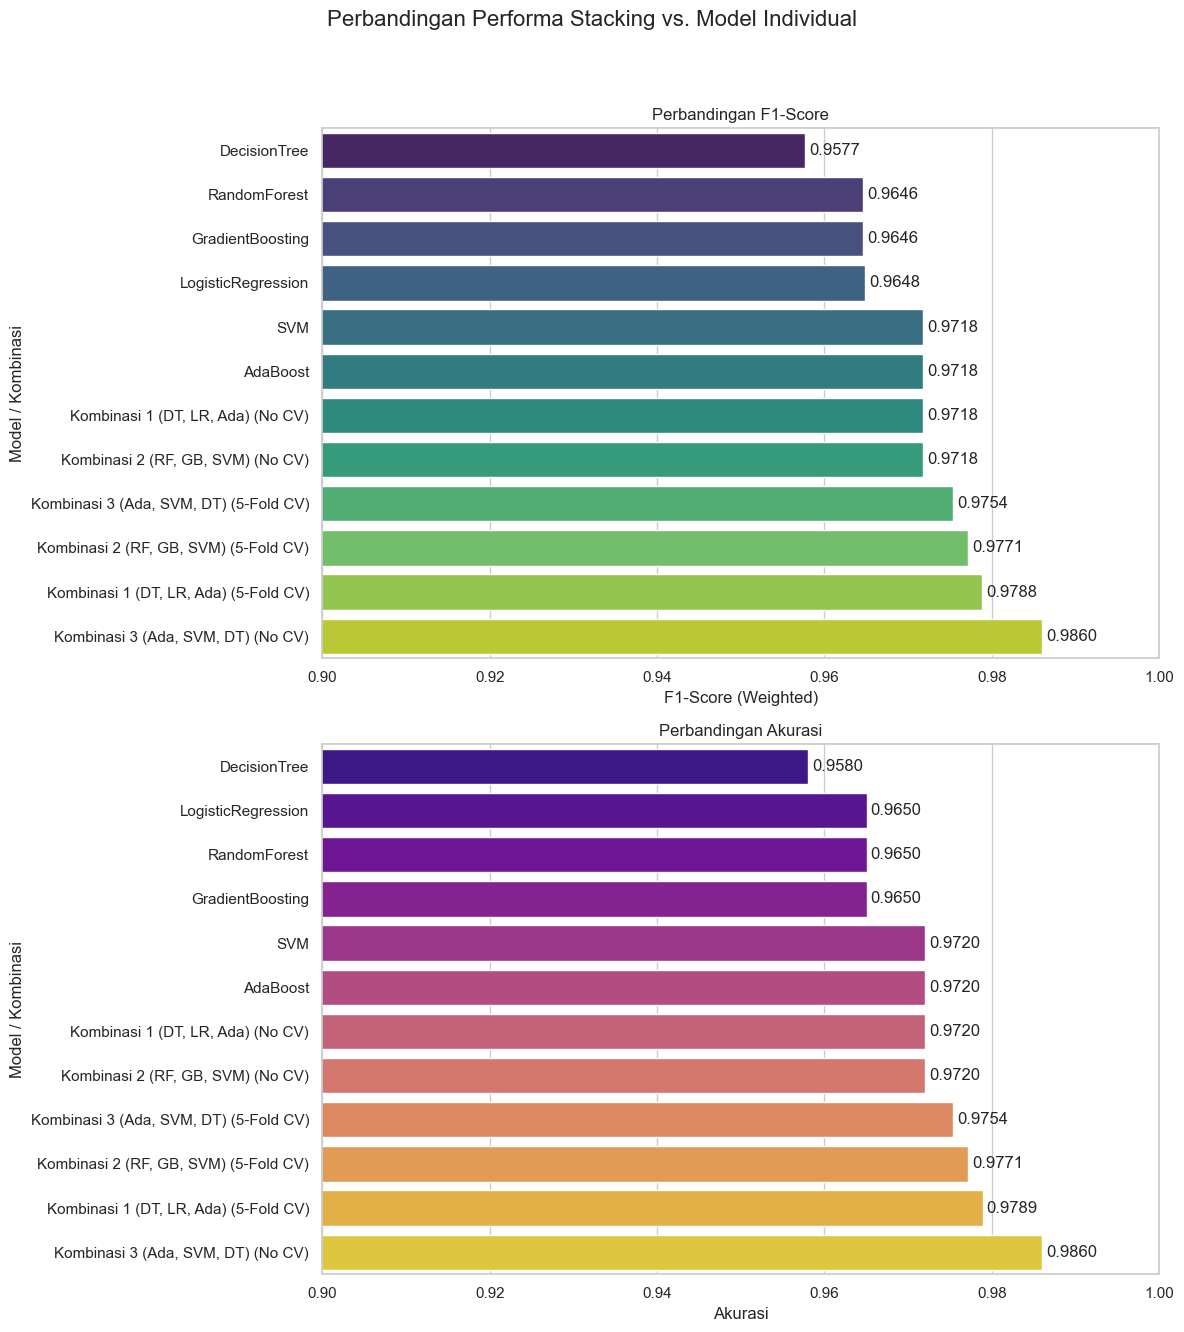

In [157]:
# Buat DataFrame hasil
results_stacking_df = pd.DataFrame(results_stacking)

# Cetak hasil akurasi dan F1-Score ke konsol
print("\n--- Hasil Perbandingan Model Stacking dan Individual ---")
print(results_stacking_df[['Model', 'Test Accuracy', 'Test F1-Score']])

# Visualisasi
fig, axes = plt.subplots(2, 1, figsize=(12, 14))
fig.suptitle('Perbandingan Performa Stacking vs. Model Individual', fontsize=16)

# Grafik 1: F1-Score (Horizontal)
sorted_df_f1 = results_stacking_df.sort_values('Test F1-Score')
ax1 = sns.barplot(ax=axes[0], x='Test F1-Score', y='Model', data=sorted_df_f1, palette='viridis', orient='h')
axes[0].set_title('Perbandingan F1-Score')
axes[0].set_xlabel('F1-Score (Weighted)')
axes[0].set_ylabel('Model / Kombinasi')
axes[0].set_xlim(0.9, 1.0)

# Tambahkan label nilai
for p in ax1.patches:
    width = p.get_width()
    axes[0].text(width + 0.0005, p.get_y() + p.get_height() / 2., f'{width:.4f}', va='center')

# Grafik 2: Akurasi (Horizontal)
sorted_df_acc = results_stacking_df.sort_values('Test Accuracy')
ax2 = sns.barplot(ax=axes[1], x='Test Accuracy', y='Model', data=sorted_df_acc, palette='plasma', orient='h')
axes[1].set_title('Perbandingan Akurasi')
axes[1].set_xlabel('Akurasi')
axes[1].set_ylabel('Model / Kombinasi')
axes[1].set_xlim(0.9, 1.0)

# Tambahkan label nilai
for p in ax2.patches:
    width = p.get_width()
    axes[1].text(width + 0.0005, p.get_y() + p.get_height() / 2., f'{width:.4f}', va='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# D. Eksperimen Super Learner

## 1. Import Library

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 2. Definisikan Base Models dan Meta Learners

In [160]:
# Base models dalam pipeline untuk konsistensi scaling
base_models = [
    ('dt', Pipeline([('scaler', StandardScaler()), ('model', DecisionTreeClassifier(random_state=42))])),
    ('lr', Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=42))])),
    ('svm', Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True, random_state=42))])),
    ('rf', Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(random_state=42))])),
    ('gb', Pipeline([('scaler', StandardScaler()), ('model', GradientBoostingClassifier(random_state=42))]))
]

# Meta learners yang akan diuji
meta_learners = {
    "LR": LogisticRegression(),
    "SVM": SVC()
}

## 3. Implementasi dan Eksperimen

In [161]:
# Lakukan 10-fold cross-validation
cv_method = KFold(n_splits=10, shuffle=True, random_state=42)

# Definisikan beberapa kombinasi base models untuk dieksplorasi
combinations = {
    "Simple Models (LR, DT, SVM)": [base_models[1], base_models[0], base_models[2]],
    "Tree Ensembles (RF, GB)": [base_models[3], base_models[4]],
    "All Models": base_models
}

results_superlearner = []
print("--- Memulai Eksperimen Super Learner ---")

# Loop untuk setiap meta-learner
for meta_name, meta_model in meta_learners.items():
    # Loop untuk setiap kombinasi base model
    for combo_name, combo_models in combinations.items():
        start_time = time.time()
        
        # Buat Super Learner (Stacking) Classifier
        super_learner = StackingClassifier(
            estimators=combo_models,
            final_estimator=meta_model,
            cv=5 # CV internal untuk melatih meta-model
        )
        
        # Evaluasi dengan 10-fold CV untuk 4 metrik sekaligus
        scoring_metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
        scores = cross_validate(super_learner, X, y_encoded, cv=cv_method, scoring=scoring_metrics, n_jobs=-1)
        
        duration = time.time() - start_time
        
        results_superlearner.append({
            "Model": f"Super Learner ({combo_name}) + Meta-{meta_name}",
            "Accuracy": np.mean(scores['test_accuracy']),
            "F1-Score": np.mean(scores['test_f1_weighted']),
            "Precision": np.mean(scores['test_precision_weighted']),
            "Recall": np.mean(scores['test_recall_weighted'])
        })
        print(f"Selesai untuk '{combo_name} + Meta-{meta_name}' dalam {duration:.2f} detik.")

results_superlearner_df = pd.DataFrame(results_superlearner)
print("\n--- Hasil Eksperimen Super Learner ---")
print(results_superlearner_df.to_string())

--- Memulai Eksperimen Super Learner ---
Selesai untuk 'Simple Models (LR, DT, SVM) + Meta-LR' dalam 4.45 detik.
Selesai untuk 'Tree Ensembles (RF, GB) + Meta-LR' dalam 7.91 detik.
Selesai untuk 'All Models + Meta-LR' dalam 5.25 detik.
Selesai untuk 'Simple Models (LR, DT, SVM) + Meta-SVM' dalam 0.36 detik.
Selesai untuk 'Tree Ensembles (RF, GB) + Meta-SVM' dalam 4.78 detik.
Selesai untuk 'All Models + Meta-SVM' dalam 5.32 detik.

--- Hasil Eksperimen Super Learner ---
                                                    Model  Accuracy  F1-Score  Precision    Recall
0   Super Learner (Simple Models (LR, DT, SVM)) + Meta-LR  0.975407  0.975388   0.975997  0.975407
1       Super Learner (Tree Ensembles (RF, GB)) + Meta-LR  0.968358  0.968313   0.969010  0.968358
2                    Super Learner (All Models) + Meta-LR  0.978947  0.978943   0.979436  0.978947
3  Super Learner (Simple Models (LR, DT, SVM)) + Meta-SVM  0.975407  0.975355   0.976202  0.975407
4      Super Learner (Tree Ense

C:\Users\madea\AppData\Local\Temp\ipykernel_20248\3609102594.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(ax=axes[0], x='Accuracy', y='Model', data=df_sorted_acc, palette='plasma', orient='h')
C:\Users\madea\AppData\Local\Temp\ipykernel_20248\3609102594.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(ax=axes[1], x='F1-Score', y='Model', data=df_sorted_f1, palette='viridis', orient='h')


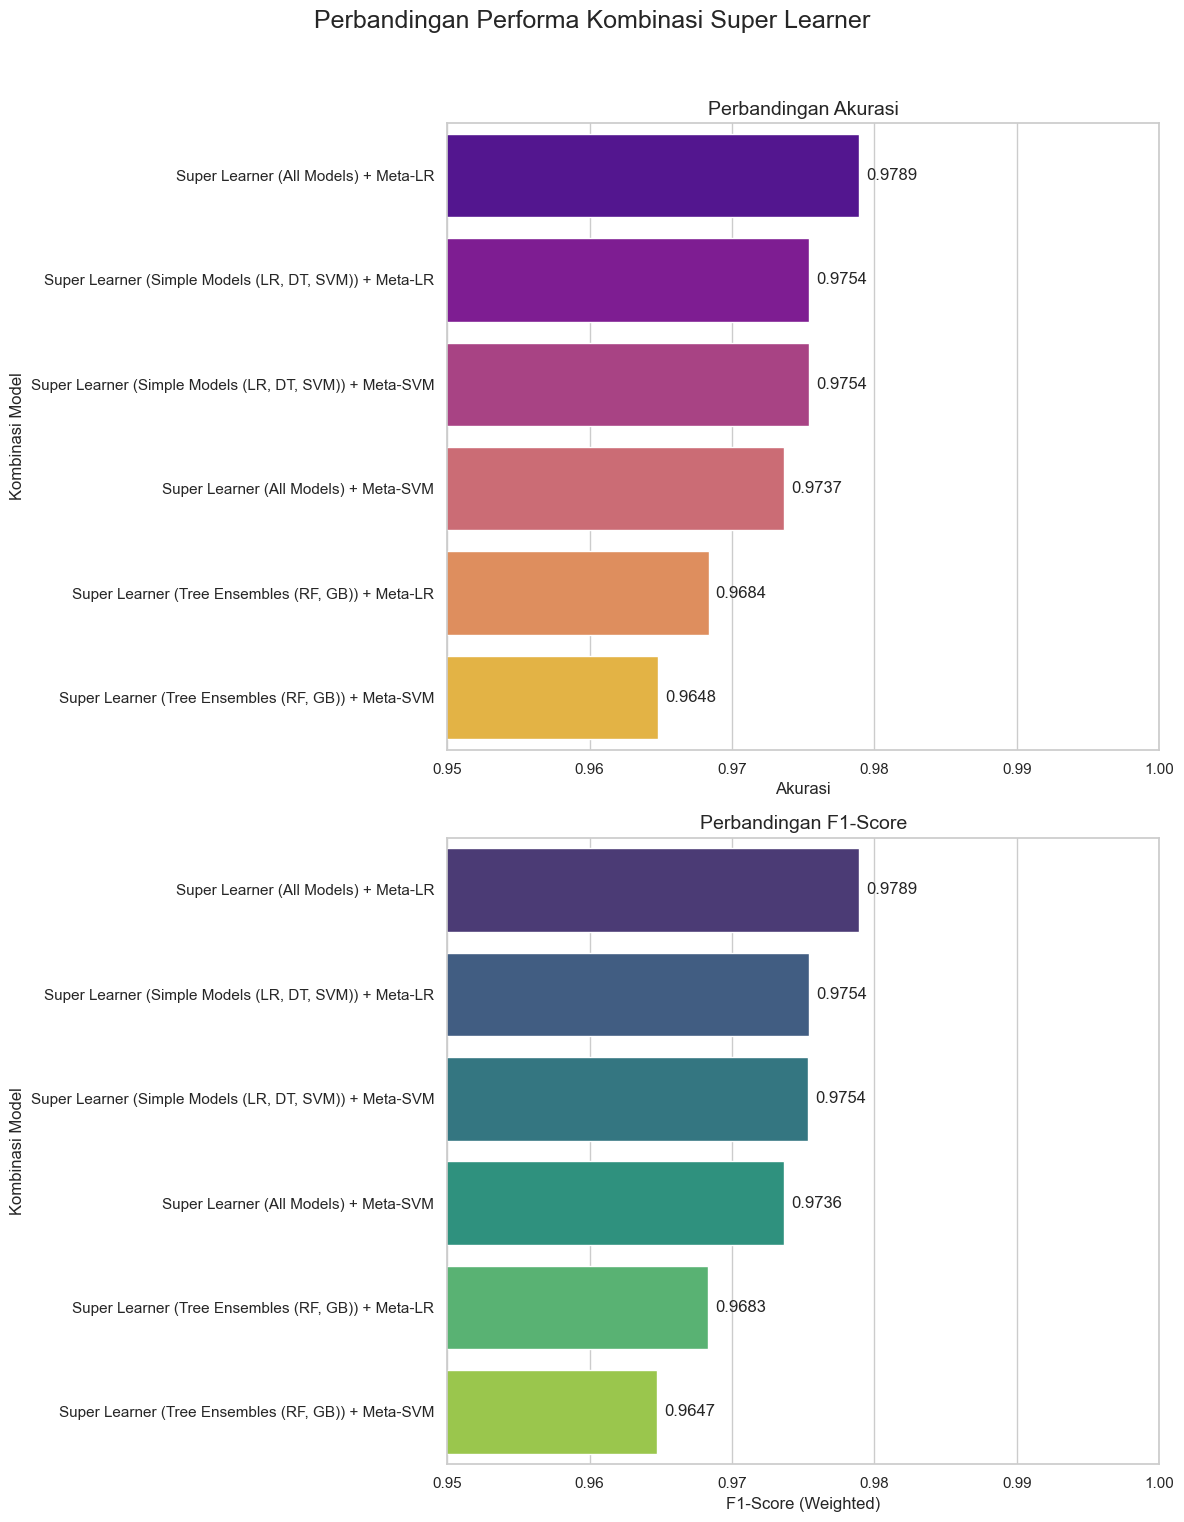

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Atur gaya visualisasi
sns.set_theme(style="whitegrid")

# --- Buat Figure dengan 2 Subplot (2 baris, 1 kolom) ---
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
fig.suptitle('Perbandingan Performa Kombinasi Super Learner', fontsize=18)

# --- Grafik 1: Perbandingan Akurasi ---
# Urutkan DataFrame berdasarkan Akurasi untuk plotting
df_sorted_acc = results_superlearner_df.sort_values('Accuracy', ascending=False)
ax1 = sns.barplot(ax=axes[0], x='Accuracy', y='Model', data=df_sorted_acc, palette='plasma', orient='h')

axes[0].set_title('Perbandingan Akurasi', fontsize=14)
axes[0].set_xlabel('Akurasi', fontsize=12)
axes[0].set_ylabel('Kombinasi Model', fontsize=12)
axes[0].set_xlim(0.95, 1.0) # Fokus pada rentang skor yang relevan

# Tambahkan label nilai untuk setiap bar
for p in ax1.patches:
    width = p.get_width()
    axes[0].text(width + 0.0005, # Posisi x sedikit di kanan bar
                 p.get_y() + p.get_height() / 2., # Posisi y di tengah bar
                 f'{width:.4f}', # Format teks nilai
                 va='center')

# --- Grafik 2: Perbandingan F1-Score ---
# Urutkan DataFrame berdasarkan F1-Score untuk plotting
df_sorted_f1 = results_superlearner_df.sort_values('F1-Score', ascending=False)
ax2 = sns.barplot(ax=axes[1], x='F1-Score', y='Model', data=df_sorted_f1, palette='viridis', orient='h')

axes[1].set_title('Perbandingan F1-Score', fontsize=14)
axes[1].set_xlabel('F1-Score (Weighted)', fontsize=12)
axes[1].set_ylabel('Kombinasi Model', fontsize=12)
axes[1].set_xlim(0.95, 1.0) # Fokus pada rentang skor yang relevan

# Tambahkan label nilai untuk setiap bar
for p in ax2.patches:
    width = p.get_width()
    axes[1].text(width + 0.0005, # Posisi x sedikit di kanan bar
                 p.get_y() + p.get_height() / 2., # Posisi y di tengah bar
                 f'{width:.4f}', # Format teks nilai
                 va='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

## 4. Perbandingan dengan Metode Ensemble Lainnya



--- Mencari Model Terbaik dari Setiap Eksperimen ---
Model Bagging terbaik: 'RandomForestClassifier' dengan F1-Score: 0.9718
Model Boosting terbaik: 'XGBoost' dengan F1-Score: 0.9860
Model Super Learner terbaik: 'Super Learner (All Models) + Meta-LR' dengan F1-Score: 0.9789


--- Tabel Perbandingan Akhir (Dihasilkan secara Dinamis) ---
                     Metode Ensemble  F1-Score
              RandomForestClassifier  0.971784
Super Learner (All Models) + Meta-LR  0.978943
                             XGBoost  0.985956


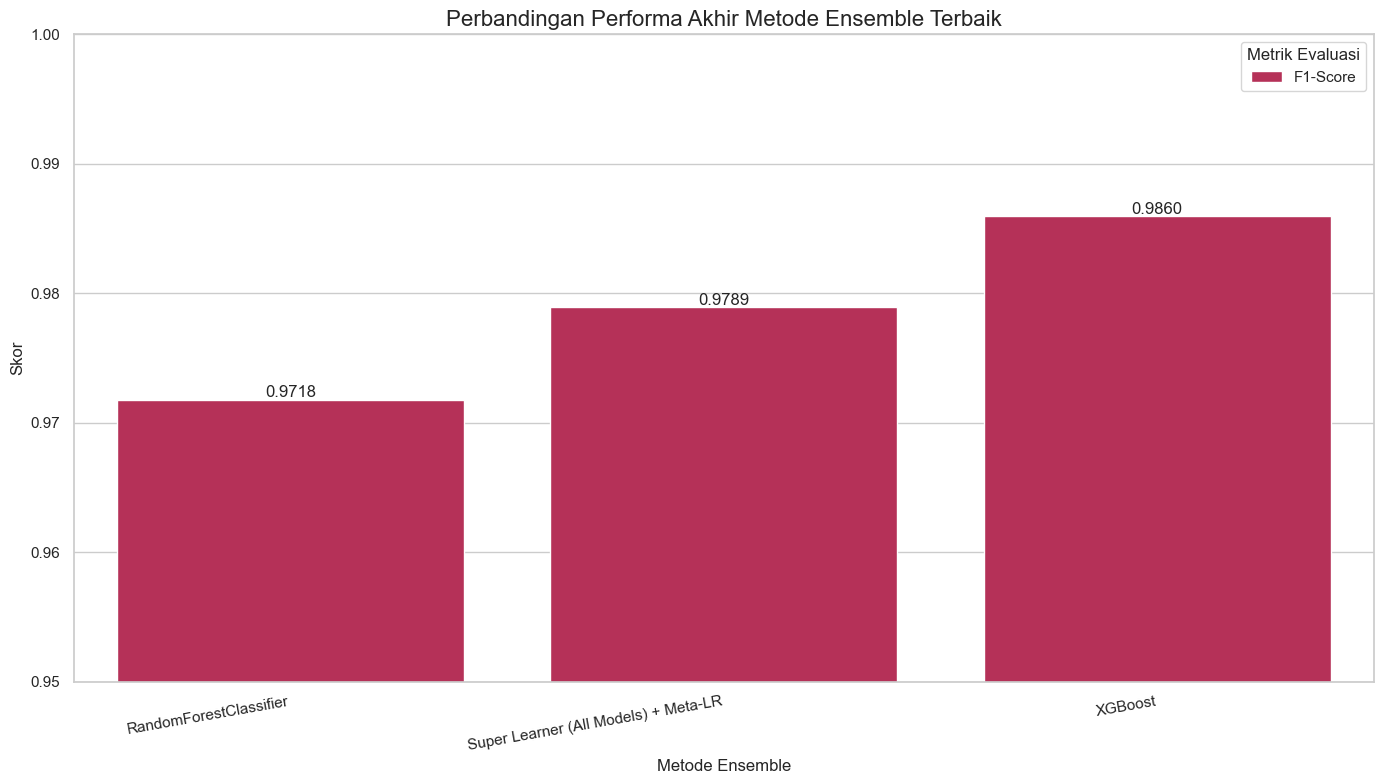

In [162]:
print("\n\n--- Mencari Model Terbaik dari Setiap Eksperimen ---")

# --- Bagian yang Diperbaiki untuk Label yang Lebih Baik ---

# Ambil seluruh baris data (termasuk nama model) dari hasil terbaik Bagging
best_bagging_row = results_bagging_df.loc[results_bagging_df[~results_bagging_df['Model'].str.contains('Baseline')]['Test F1-Score'].idxmax()]
best_bagging_f1 = best_bagging_row['Test F1-Score']
best_bagging_model_name = best_bagging_row['Model'] # Ambil nama modelnya
print(f"Model Bagging terbaik: '{best_bagging_model_name}' dengan F1-Score: {best_bagging_f1:.4f}")

# Lakukan hal yang sama untuk Boosting
best_boosting_row = results_boosting_df.loc[results_boosting_df[~results_boosting_df['Model'].str.contains('Baseline')]['Test F1-Score'].idxmax()]
best_boosting_f1 = best_boosting_row['Test F1-Score']
best_boosting_model_name = best_boosting_row['Model'] # Ambil nama modelnya
print(f"Model Boosting terbaik: '{best_boosting_model_name}' dengan F1-Score: {best_boosting_f1:.4f}")

# Dan untuk Super Learner
best_superlearner_row = results_superlearner_df.loc[results_superlearner_df['F1-Score'].idxmax()]
best_superlearner_f1 = best_superlearner_row['F1-Score']
best_superlearner_model_name = best_superlearner_row['Model'] # Ambil nama modelnya
print(f"Model Super Learner terbaik: '{best_superlearner_model_name}' dengan F1-Score: {best_superlearner_f1:.4f}")


# Buat DataFrame perbandingan akhir dengan nama model yang bersih
final_comparison_df = pd.DataFrame({
    "Metode Ensemble": [best_bagging_model_name, best_boosting_model_name, best_superlearner_model_name],
    "F1-Score": [best_bagging_f1, best_boosting_f1, best_superlearner_f1]
}).sort_values("F1-Score", ascending=True) # Urutkan ascending untuk plot horizontal yang bagus

print("\n\n--- Tabel Perbandingan Akhir (Dihasilkan secara Dinamis) ---")
print(final_comparison_df.to_string(index=False))


# --- Visualisasi Horizontal yang Diperbaiki ---
final_comparison_melted = final_comparison_df.melt(id_vars="Metode Ensemble", var_name="Metrik", value_name="Skor")

plt.figure(figsize=(14, 8))
ax = sns.barplot(x="Metode Ensemble", y="Skor", hue="Metrik", data=final_comparison_melted, palette="rocket")
plt.title('Perbandingan Performa Akhir Metode Ensemble Terbaik', fontsize=16)
plt.ylabel('Skor')
plt.xlabel('Metode Ensemble')
plt.ylim(0.95, 1.0)
plt.xticks(rotation=10, ha='right')
plt.legend(title='Metrik Evaluasi')

# Tambahkan label nilai
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()